In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import gseapy as gp
from gseapy.plot import barplot, dotplot

In [2]:
import CPTAC.Endometrial as en

Welcome to the CPTAC data service package. Available datasets may be
viewed using CPTAC.list_data(). In order to access a specific data
set, import a CPTAC subfolder using either 'import CPTAC.Dataset' or
'from CPTAC import Dataset'.
******
Version: 0.2.7
******
Loading Endometrial CPTAC data:
Loading Dictionary...
Loading Clinical Data...
Loading Acetylation Proteomics Data...
Loading Proteomics Data...
Loading Transcriptomics Data...
Loading CNA Data...
Loading Phosphoproteomics Data...
Loading Somatic Mutation Data...

 ******PLEASE READ******
CPTAC is a community resource project and data are made available
rapidly after generation for community research use. The embargo
allows exploring and utilizing the data, but the data may not be in a
publication until July 1, 2019. Please see
https://proteomics.cancer.gov/data-portal/about/data-use-agreement or
enter embargo() to open the webpage for more details.


In [3]:
clinical = en.get_clinical()
proteomics = en.get_proteomics()

In [4]:
tumorProt = en.compare_clinical(clinical_col='Proteomics_Tumor_Normal', omics_data=proteomics)

In [5]:
tumorProt.head()

idx  Proteomics_Tumor_Normal   A1BG     A2M  A2ML1  A4GALT    AAAS    AACS  \
S001                   Tumor -1.180 -0.8630 -0.802   0.222  0.2560  0.6650   
S002                   Tumor -0.685 -1.0700 -0.684   0.984  0.1350  0.3340   
S003                   Tumor -0.528 -1.3200  0.435     NaN -0.2400  1.0400   
S005                   Tumor -1.670 -1.1900 -0.443   0.243 -0.0993  0.7570   
S006                   Tumor -0.374 -0.0206 -0.537   0.311  0.3750  0.0131   

idx    AADAT   AAED1  AAGAB  ...   ZSWIM8  ZSWIM9    ZW10  ZWILCH  ZWINT  \
S001  1.2800 -0.3390  0.412  ... -0.08770     NaN  0.0229  0.1090    NaN   
S002  1.3000  0.1390  1.330  ... -0.03560     NaN  0.3630  1.0700  0.737   
S003 -0.0213 -0.0479  0.419  ...  0.00112 -0.1450  0.0105 -0.1160    NaN   
S005  0.7400 -0.9290  0.229  ...  0.07250 -0.0552 -0.0714  0.0933  0.156   
S006 -1.1000     NaN  0.565  ... -0.17600     NaN -1.2200 -0.5620  0.937   

idx    ZXDC   ZYG11B    ZYX   ZZEF1    ZZZ3  
S001 -0.332 -0.43300 -1.020 -0.1230 -0.0859  
S002 -0.564 -0.00461 -1.130 -0.0757 -0.4730  
S003  0.151 -0.07400 -0.540  0.3200 -0.4190  
S005 -0.398 -0.07520 -0.797 -0.0301 -0.4670  
S006 -0.646  0.20700 -1.850 -0.1760  0.0513  

[5 rows x 11000 columns]

In [6]:
tumor_bool = tumorProt['Proteomics_Tumor_Normal'] == "Tumor"
normal_bool = tumorProt['Proteomics_Tumor_Normal'] != "Tumor"
tumor = tumorProt[tumor_bool]
#tumor.head()
normal = tumorProt[normal_bool]
normal.head()

idx  Proteomics_Tumor_Normal   A1BG    A2M  A2ML1  A4GALT    AAAS   AACS  \
S105         Adjacent_normal  1.700  1.420  0.444   0.398 -0.0394 -0.604   
S106         Adjacent_normal  0.109 -0.579  0.226     NaN -0.1350 -0.363   
S107         Adjacent_normal  0.437  0.456    NaN     NaN -0.0377 -0.720   
S108         Adjacent_normal  0.937  0.283    NaN     NaN  0.1950 -0.798   
S109         Adjacent_normal  0.581 -0.784  0.418  -0.123 -0.2490 -0.845   

idx     AADAT  AAED1  AAGAB  ...  ZSWIM8  ZSWIM9   ZW10  ZWILCH   ZWINT  \
S105 -0.19500  0.209 -0.555  ... -0.2520     NaN -0.297  -0.130     NaN   
S106 -0.10400  0.328 -1.110  ...  0.0236   0.283 -0.135   0.189     NaN   
S107  0.02180  0.488 -0.469  ...  0.0162     NaN -0.281  -0.551 -0.2960   
S108  0.00836  1.270 -0.850  ... -0.0741     NaN -0.352  -0.499 -0.0512   
S109 -0.12100  0.352 -0.482  ...  0.1450     NaN -0.283  -0.454     NaN   

idx    ZXDC  ZYG11B   ZYX   ZZEF1     ZZZ3  
S105  0.721   0.309  1.08 -0.1370  0.14400  
S106  0.340   0.275  1.87  0.1530  0.47800  
S107  0.258   0.346  1.57  0.1300  0.00555  
S108  0.562   0.314  1.23 -0.0285  0.46100  
S109  0.557   0.186  1.58 -0.1590  0.40000  

[5 rows x 11000 columns]

In [8]:
tumor_genes = []
normal_genes = []
genes = tumor.columns[1:]
threshold = .05 / len(genes)
#Perform Welch's t-test(different variances) on each gene between the two groups
for gene in genes:
    tumor_gene_abundance = tumor[gene]
    normal_gene_abundance = normal[gene]
    pvalue = stats.ttest_ind(tumor_gene_abundance, normal_gene_abundance, equal_var = False, nan_policy='omit').pvalue
    #If the P-value is significant, determine which partition is more highly expressed
    if pvalue < threshold:
        if tumor_gene_abundance.mean() > normal_gene_abundance.mean():
            tumor_genes.append(gene.split("_")[0])
        elif normal_gene_abundance.mean() > tumor_gene_abundance.mean():
            normal_genes.append(gene.split("_")[0])
#Optional check of number of genes in each partition
print("Proteomics Tumor Genes:", len(tumor_genes))
print("Proteomics Normal Genes:", len(normal_genes))

Proteomics Tumor Genes: 2154
Proteomics Normal Genes: 2237


In [16]:
#warning: read_table deprecated
tumor_enr = gp.enrichr(gene_list = tumor_genes, description='Tumor partition', gene_sets='KEGG_2016', outdir='test/enrichr_kegg',cutoff=.05)
normal_enr = gp.enrichr(gene_list = normal_genes, description='Normal partition', gene_sets='KEGG_2016', outdir='test/enrichr_kegg',cutoff=.05)
#changed cutoff to .05

C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\gseapy\enrichr.py:133: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  res = pd.read_table(StringIO(response.content.decode('utf-8')))
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\gseapy\enrichr.py:133: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  res = pd.read_table(StringIO(response.content.decode('utf-8')))


In [15]:
tumor_enr.res2d.head()

Term   Overlap       P-value  \
0                     Ribosome_Homo sapiens_hsa03010    81/137  2.901971e-43   
1                   Proteasome_Homo sapiens_hsa03050     32/44  4.996777e-22   
2           Metabolic pathways_Homo sapiens_hsa01100  210/1239  7.212527e-12   
3                     Lysosome_Homo sapiens_hsa04142    41/123  1.496473e-11   
4  Protein processing in endoplasmic reticulum_Ho...    48/169  1.730328e-10   

   Adjusted P-value   Old P-value  Old Adjusted P-value   Z-score  \
0      8.328657e-41  2.144078e-22          6.153504e-20 -1.746138   
1      7.170375e-20  2.988372e-11          4.288313e-09 -1.687623   
2      6.899984e-10  8.962487e-04          2.004763e-02 -1.961922   
3      1.073719e-09  2.652680e-06          2.537731e-04 -1.699249   
4      9.932085e-09  1.486739e-05          1.066735e-03 -1.718807   

   Combined Score                                              Genes  \
0      171.026834  RPL4;RPL5;MRPS15;RPL30;RPL3;MRPS11;RPLP1;RPLP0...   
1       82.774666  PSMD12;PSMD11;PSMD14;PSMD13;PSMA7;PSMB10;PSMD8...   
2       50.333509  PANK1;ENO1;EPRS;IL4I1;C1GALT1C1;NSDHL;PNP;SCP2...   
3       42.354336  CD63;ASAH1;HEXB;CTSZ;HEXA;CLTC;CLTA;LIPA;CTSS;...   
4       38.634550  VCP;HSP90AB1;PRKCSH;SAR1B;RPN1;RRBP1;RNF5;HERP...   

    Gene_set  
0  KEGG_2016  
1  KEGG_2016  
2  KEGG_2016  
3  KEGG_2016  
4  KEGG_2016

In [17]:
normal_enr.res2d.head()

Term Overlap       P-value  \
0  Complement and coagulation cascades_Homo sapie...   45/79  5.520692e-23   
1               Focal adhesion_Homo sapiens_hsa04510  74/202  1.656914e-21   
2                  Endocytosis_Homo sapiens_hsa04144  75/259  3.293706e-15   
3           Pathways in cancer_Homo sapiens_hsa05200  96/397  1.323995e-13   
4       MAPK signaling pathway_Homo sapiens_hsa04010  71/255  1.549617e-13   

   Adjusted P-value   Old P-value  Old Adjusted P-value   Z-score  \
0      1.468504e-20  7.294727e-14          1.087878e-11 -1.824138   
1      2.203695e-19  8.179537e-14          1.087878e-11 -1.896862   
2      2.920420e-13  6.382194e-10          5.658878e-08 -1.912425   
3      8.243961e-12  7.929762e-09          4.218633e-07 -2.029699   
4      8.243961e-12  7.484993e-09          4.218633e-07 -1.895949   

   Combined Score                                              Genes  \
0       93.488831  CFD;CPB2;SERPINA1;CFH;C1S;SERPINC1;C1R;PROS1;C...   
1       90.763583  ITGB3;PTEN;PIK3CD;ILK;LAMC1;MYLK3;MYLK;CRKL;AK...   
2       63.773169  ZFYVE9;ARPC1A;WIPF3;CLTB;SNX12;AP2A1;ARRB1;WAS...   
3       60.186566  CDKN1B;PTEN;PIK3CD;LAMC1;FGF1;FGF2;CRKL;IKBKB;...   
4       55.922153  ATF2;HSPB1;ARRB1;FGF1;FGF2;CRKL;IKBKB;RPS6KA4;...   

    Gene_set  
0  KEGG_2016  
1  KEGG_2016  
2  KEGG_2016  
3  KEGG_2016  
4  KEGG_2016

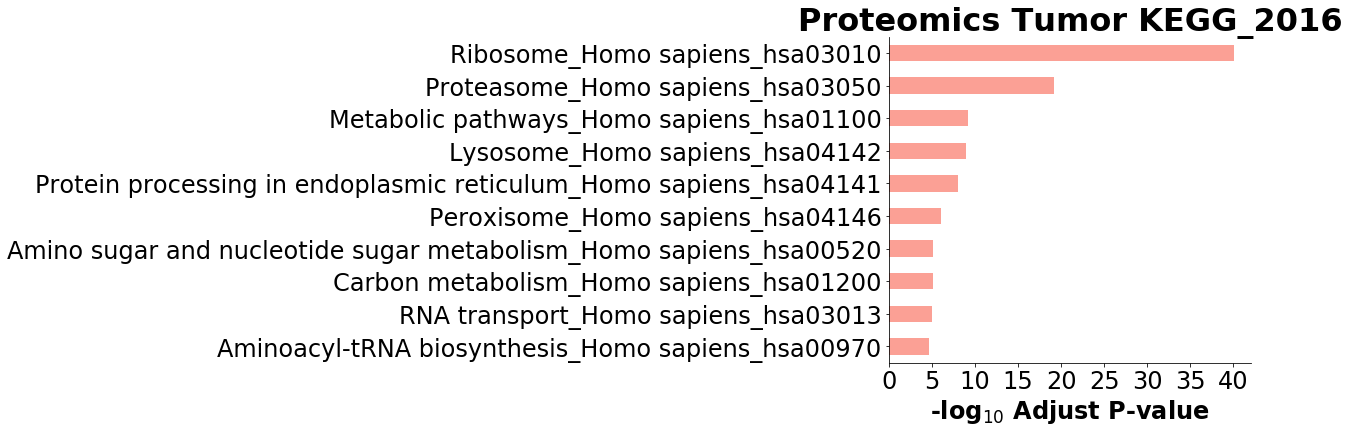

In [12]:
barplot(tumor_enr.res2d,title="Proteomics Tumor KEGG_2016")

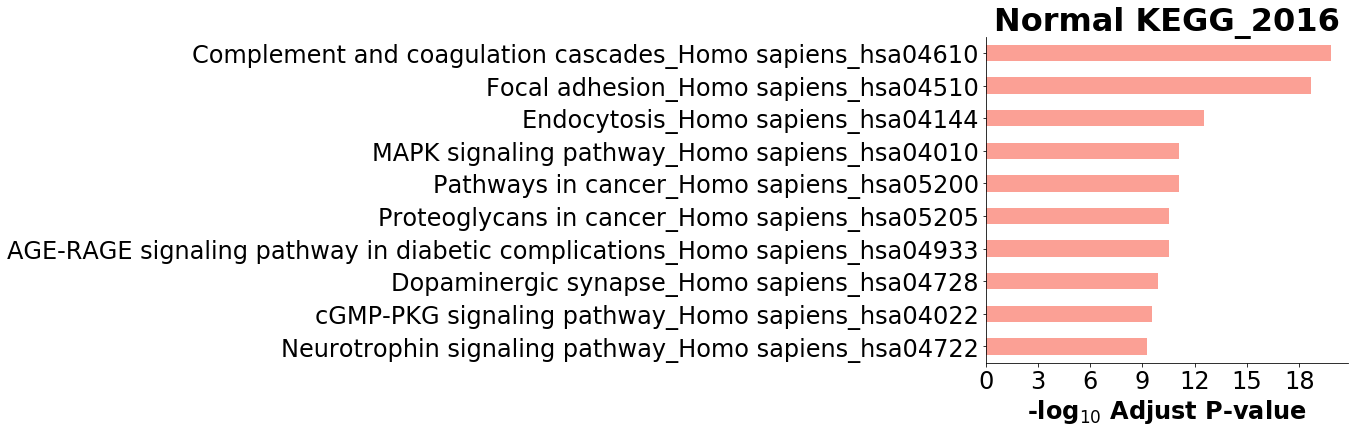

In [13]:
barplot(normal_enr.res2d,title="Normal KEGG_2016")